In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib

def load_metadata():
  file_path = Path("data/train.csv")
  return pd.read_csv(file_path)
  
metadata = load_metadata()

def extract_eeg():
  eeg_dir = Path("../data/eeg")
  tarball_path = Path("data/eeg.tar.gz")
  if not tarball_path.is_file():
    url = 'https://dl.dropboxusercontent.com/scl/fi/5sina48c4naaxv6uze0fv/eeg.tar.gz?rlkey=r7ec191extynfcm8fy0tsiws5&dl=0'
    urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as eeg_tarball:
      eeg_tarball.extractall()
    
extract_eeg()

metadata


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,4144388963,140,604.0,1156825996,140,604.0,1451266906,59489,GRDA,0,0,0,0,3,0
1,2353475448,30,64.0,1002394133,30,64.0,4000072340,5339,LRDA,0,0,0,3,0,0
2,1618328341,9,52.0,900482955,9,52.0,4140697659,20198,GRDA,0,0,0,0,3,0
3,979865826,7,90.0,1626043434,7,90.0,919550440,1069,Other,1,1,4,1,4,5
4,521108392,0,0.0,827447277,0,0.0,1717414556,13134,Other,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2509824693,10,68.0,1005228554,15,330.0,219919562,14386,LPD,0,11,0,1,1,2
996,2882719839,14,50.0,2035369578,14,50.0,4193559045,2641,GPD,5,0,11,0,0,0
997,1322226281,2,18.0,1740512896,2,18.0,1697286566,49448,Other,0,0,0,0,0,3
998,628369060,15,98.0,13143748,17,292.0,1650460145,34998,GPD,0,3,7,0,2,4


In [2]:
# Visualization
import dask.dataframe as dd
import numpy as np

channels = ['Fp1', 'Fp2',
            'F7', 'F3', 'Fz', 'F4', 'F8', 
            'T3', 'C3', 'Cz', 'C4', 'T4', 
            'T5', 'P3', 'Pz', 'P4', 'T6', 
            'O1', 'O2',
            ]
sfreq = 200

sig_file = './data/eeg/2509824693.parquet'
raw_ddf = dd.read_parquet(sig_file, engine='fastparquet').compute()
raw_ddf = raw_ddf[channels]
raw_ddf


,Fp1,Fp2,F7,F3,Fz,F4,F8,T3,C3,Cz,C4,T4,T5,P3,Pz,P4,T6,O1,O2
0,91.980003,54.500000,70.980003,69.650002,57.950001,35.360001,-29.510000,79.750000,52.639999,35.889999,18.080000,-30.309999,35.360001,25.250000,30.570000,14.620000,-17.549999,22.330000,2.13
1,86.129997,48.650002,57.950001,56.360001,49.980000,24.459999,-40.939999,81.080002,51.040001,28.180000,9.300000,-36.150002,-17.549999,26.320000,25.250000,9.570000,-20.740000,13.560000,-4.25
2,76.300003,46.520000,52.099998,47.320000,39.340000,16.480000,-50.509998,40.410000,38.549999,19.410000,3.720000,-31.629999,29.240000,27.910000,21.799999,6.110000,-31.900000,16.219999,-5.58
3,82.940002,52.900002,72.309998,51.310001,42.270000,22.860001,-42.000000,64.070000,1.860000,12.760000,-3.990000,-32.700001,31.370001,15.950000,19.139999,3.460000,-19.139999,14.090000,-6.38
4,93.839996,65.660004,74.970001,56.889999,56.360001,41.470001,-14.620000,56.619999,45.459999,30.040001,19.410000,-30.570000,35.619999,32.700001,34.290001,19.139999,-10.630000,23.930000,3.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26795,51.310001,40.410000,40.669998,38.810001,49.709999,51.310001,23.129999,14.890000,25.250000,46.790001,36.419998,43.860001,13.290000,9.040000,25.790001,14.890000,5.320000,2.390000,7.98
26796,42.000000,33.759998,27.910000,26.580000,39.610001,43.070000,11.430000,3.460000,11.700000,34.290001,26.580000,30.040001,1.060000,-2.390000,10.630000,2.390000,-13.290000,-10.100000,-2.66
26797,35.619999,21.530001,27.650000,24.990000,35.360001,33.230000,3.190000,3.720000,13.290000,31.100000,19.410000,24.459999,1.060000,-0.800000,8.770000,-3.460000,-12.760000,-7.710000,-8.24
26798,29.510000,13.820000,24.459999,22.330000,30.840000,29.510000,0.270000,-1.860000,10.900000,29.240000,17.809999,24.719999,-1.860000,-3.990000,7.180000,-3.990000,-12.490000,-8.510000,-10.37


Creating RawArray with float64 data, n_channels=19, n_times=26800
    Range : 0 ... 26799 =      0.000 ...   133.995 secs
Ready.
Using matplotlib as 2D backend.


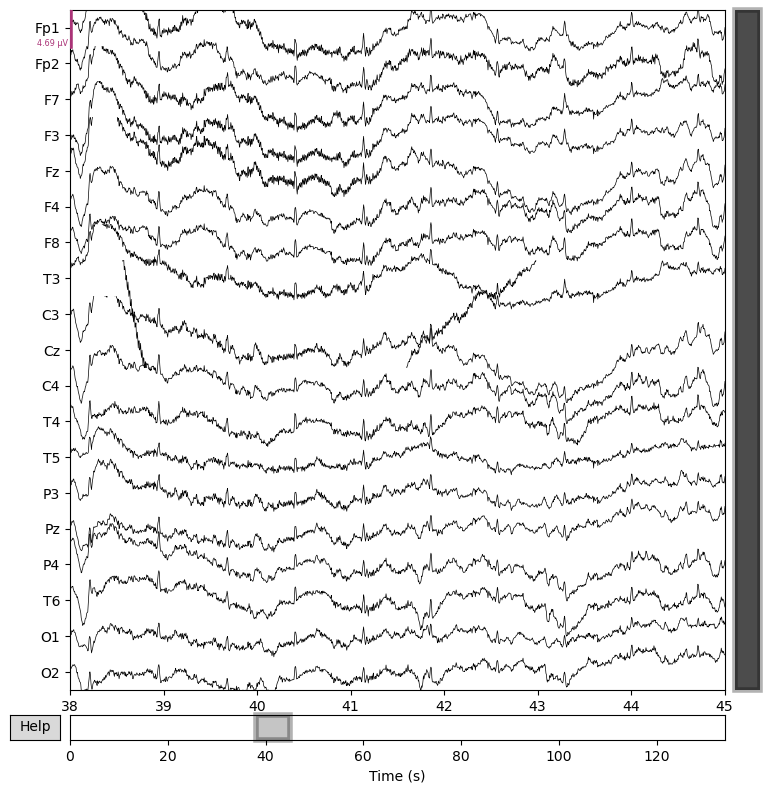

In [3]:
import mne
import matplotlib.pyplot as plt

info = mne.create_info(ch_names = raw_ddf.columns.tolist(), sfreq=sfreq, ch_types='eeg')
info.set_montage('standard_1020')
data = np.array(raw_ddf.transpose())
data = np.nan_to_num(data)

raw = mne.io.RawArray(data, info)
raw.apply_function(lambda x: x / 20e6, picks='eeg')

# Plot signals
raw.plot(start=38, duration=7, scalings={'eeg': 'auto'}, show=True);

Applying baseline correction (mode: mean)


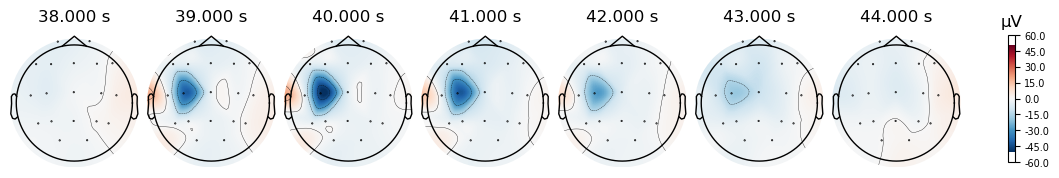

In [4]:
# plot topographic map for this signal
evoked = mne.EvokedArray(raw.get_data(), info, baseline=(0, 0))
times = np.arange(38, 45, 1)
evoked.plot_topomap(ch_type="eeg", times=times);